## 📌 0. Import Packages

In [117]:
##  Import Packages
import numpy as np
import pandas as pd
import plotly 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) # show all of columns

## 📥 1. Data Preparation


### 1.1 Import csv file

In [118]:
# Load data 
df = pd.read_csv('Car_sale_ads.csv')
print(f'shape of data: {df.shape}')
df.head(3)

shape of data: (208304, 25)


,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,CO2_emissions,Drive,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.00,145.00,"1,400.00",Gasoline,NaN,Front wheels,Manual,small_cars,3.00,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,"59,000.00",75.00,"1,100.00",Gasoline,NaN,Front wheels,Manual,coupe,2.00,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,"52,000.00",180.00,"1,368.00",Gasoline,NaN,NaN,Automatic,small_cars,3.00,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."


In [119]:
# Create a copy from dataset
df_copy = df.copy()

##### 📌 The dataset contains detailed information about car sale ads. To detect unusual or suspicious offers, we can proceed with the following steps:

## 🔍 2. Data Exploration

### 2.1 Initial Observations from the Dataset


In [103]:
pd.set_option('display.max_columns', None)
pd.DataFrame(df_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Index                    208304 non-null  int64  
 1   Price                    208304 non-null  int64  
 2   Currency                 208304 non-null  object 
 3   Condition                208304 non-null  object 
 4   Vehicle_brand            208304 non-null  object 
 5   Vehicle_model            208304 non-null  object 
 6   Vehicle_version          138082 non-null  object 
 7   Vehicle_generation       147860 non-null  object 
 8   Production_year          208304 non-null  int64  
 9   Mileage_km               207321 non-null  float64
 10  Power_HP                 207661 non-null  float64
 11  Displacement_cm3         206338 non-null  float64
 12  Fuel_type                208304 non-null  object 
 13  CO2_emissions            94047 non-null   float64
 14  Driv

""


#### 📊 Key Features :

- Price: This is a primary variable to check for anomalies.

- Currency: Ensures price standardization.

- Condition: Differentiates between new and used cars.

- Vehicle details: Includes brand, model, year, mileage, and type.

- Location and Dates: May provide temporal or geographic trends.


In [104]:
# Create consistency in price : Convert PLN to EUR
# Average exchange rate in 2021: 0.2191 EUR.(Google search)

Avg_exchange_rate_2021 = 0.2191

#  modify the original DataFrame safely
df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] = (
    df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] * Avg_exchange_rate_2021
)

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_35565/4018092414.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[18886.42  9530.85  9837.59 ...  1511.79  1248.87  2607.29]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[df_copy['Currency'] == 'PLN', 'Price'] = (


In [105]:
# Dropping unnecessary columns for clustering.
# Columns to drop: 'CO2_emissions', 'First_owner', 'First_registration_date', 'Offer_publication_date', 'Index'

df_copy = df_copy.drop(['Index',  'Currency', 'Vehicle_model',
        'Vehicle_version', 'Vehicle_generation',
        'CO2_emissions', 'Transmission', 
       'Doors_number', 'Colour', 'Origin_country', 'First_owner',
       'First_registration_date', 'Offer_publication_date', 'Offer_location',
       'Features'
], axis=1)

### 2.2 Univariate analysis

### 2.2.1 Glance at Numerical feature

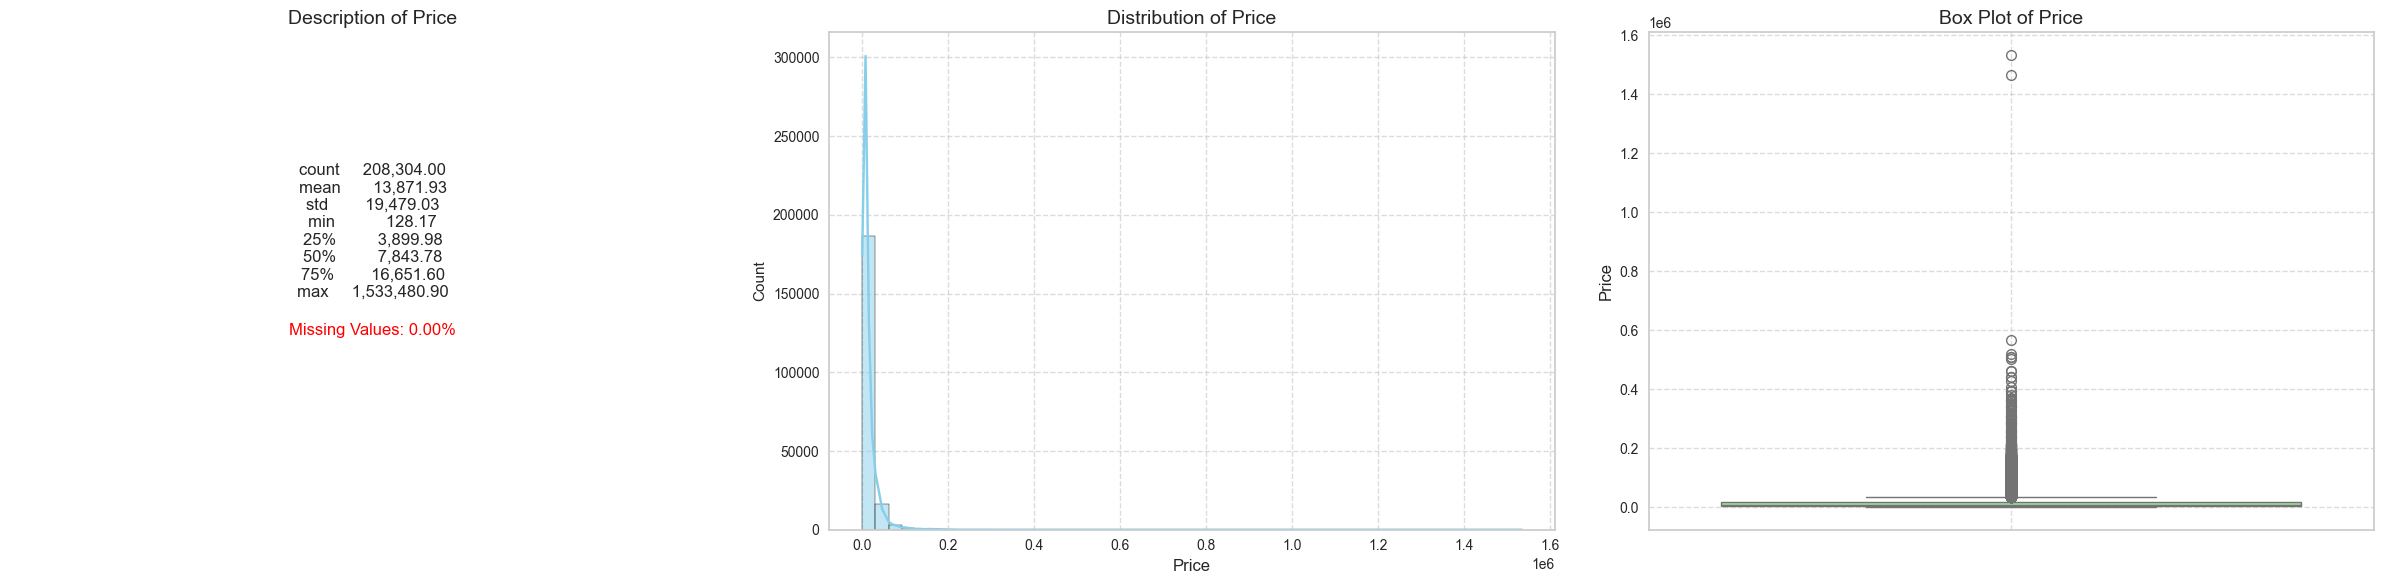

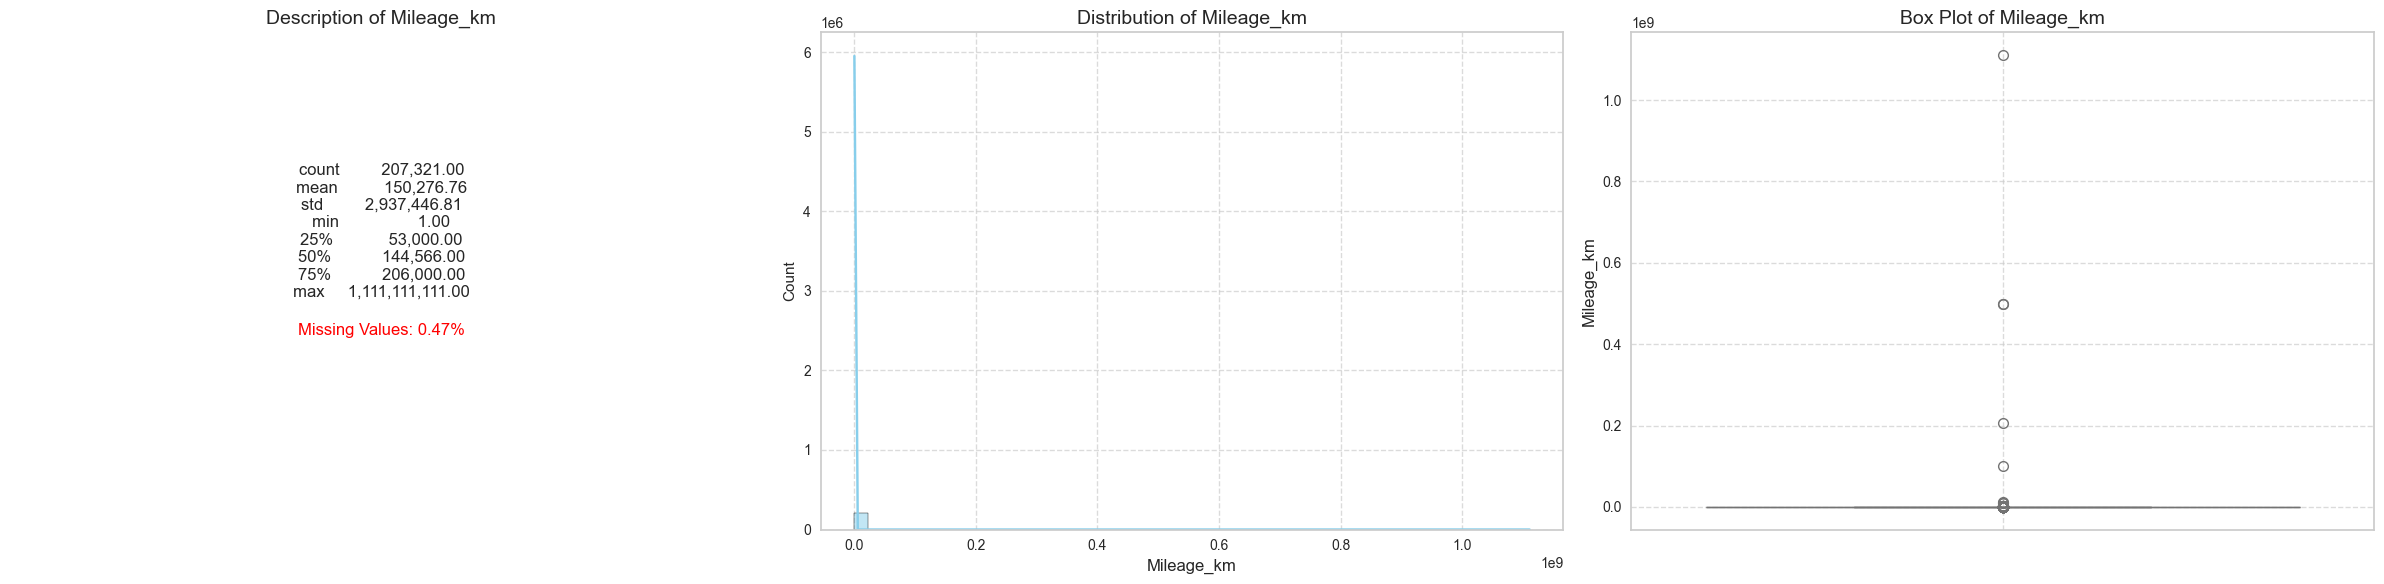

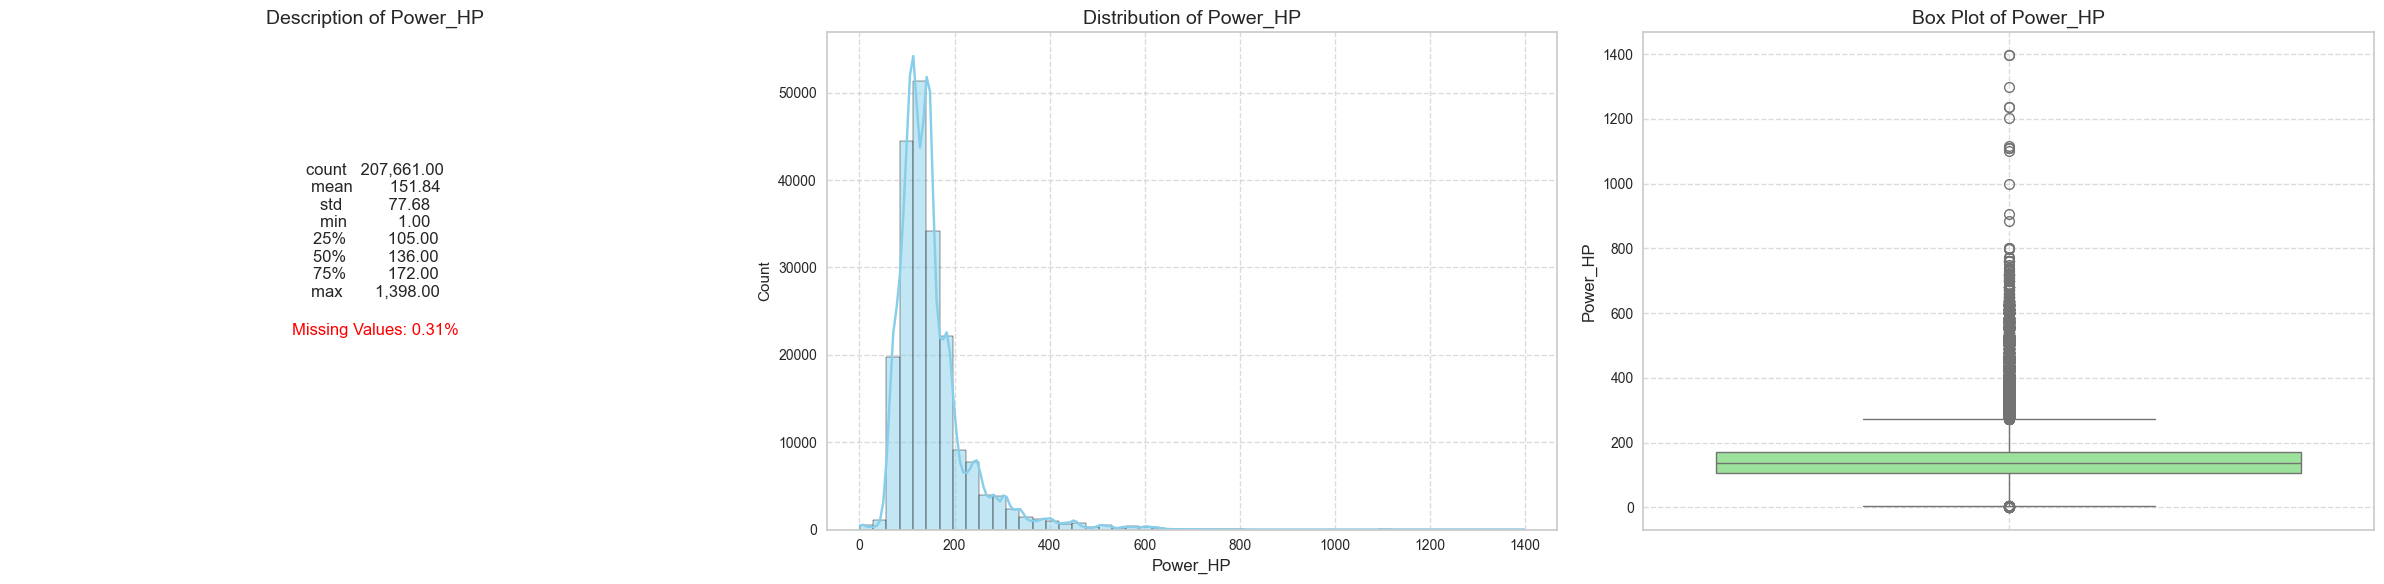

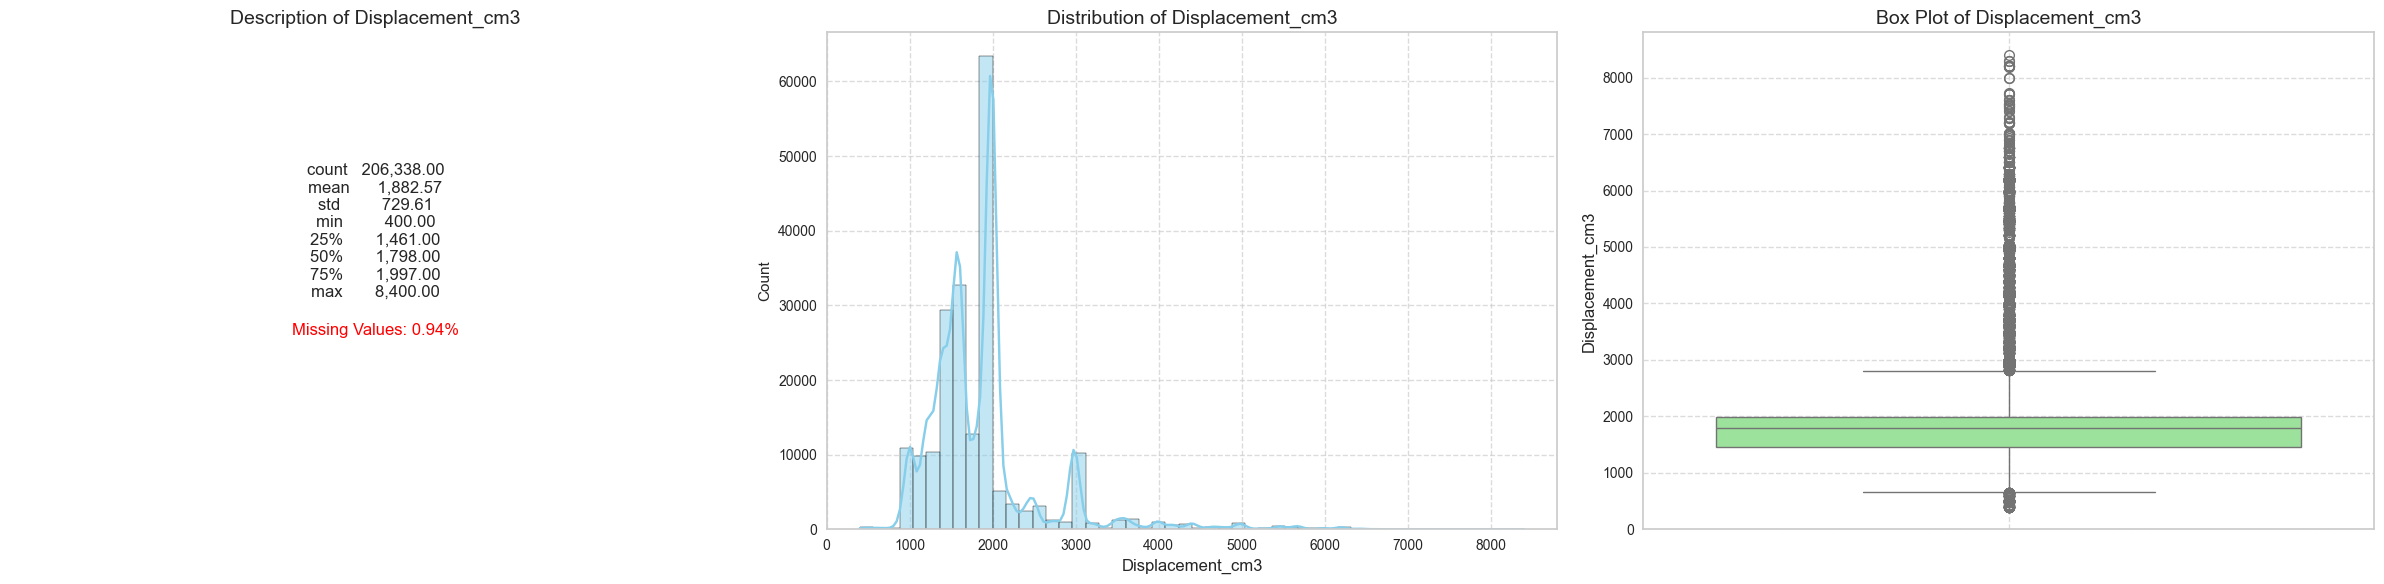

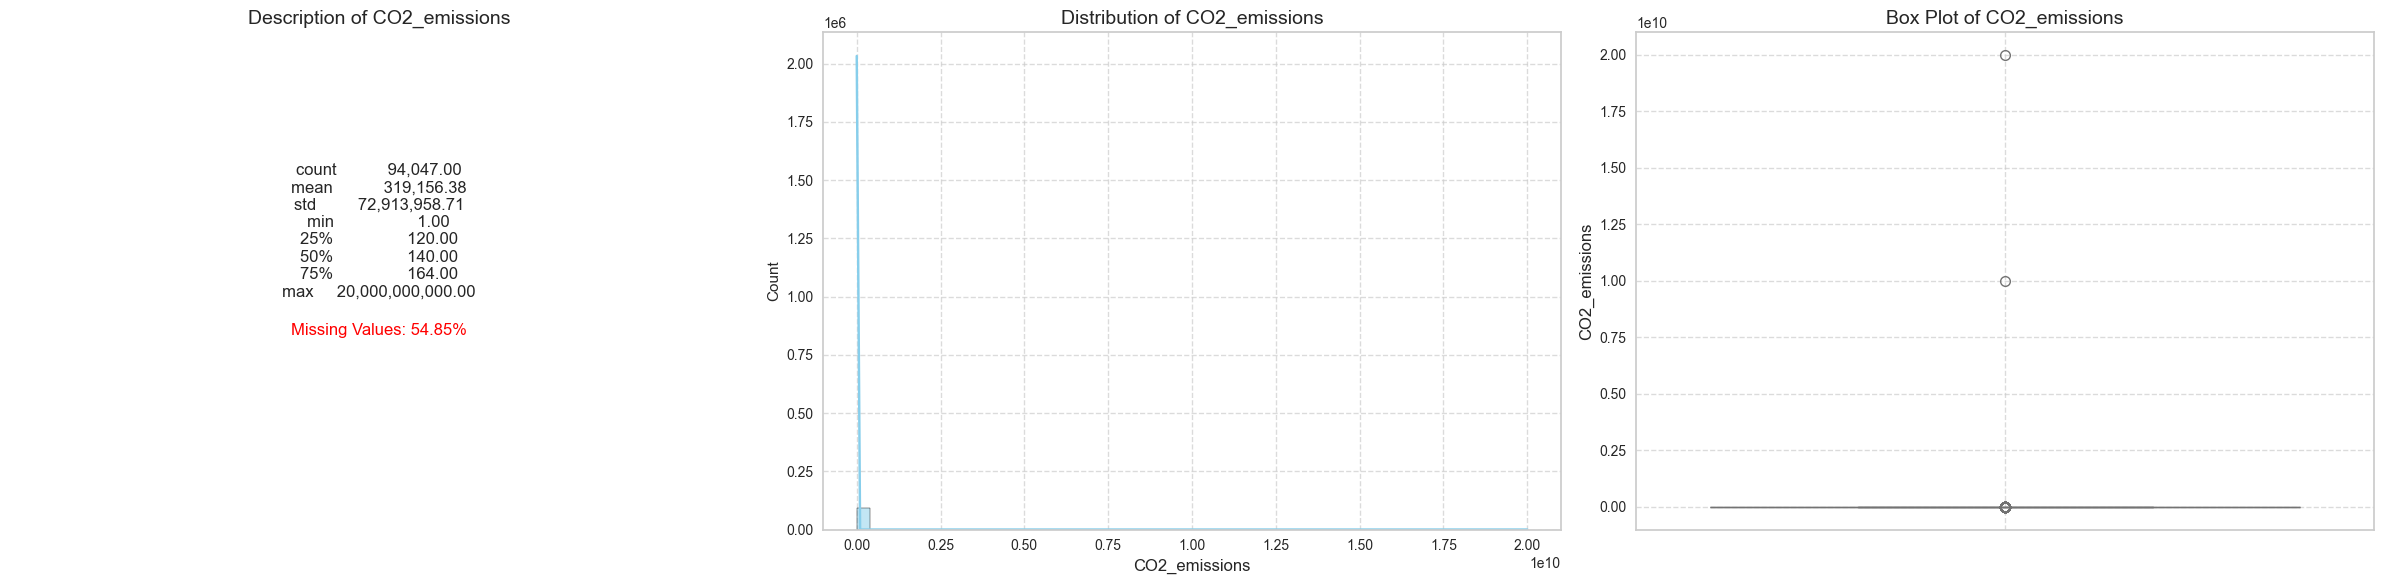

In [5]:
# Create a function to display Distribution and Summary Statistics of numerical value

def plot_column_analysis(data, columns_list):
    for column in columns_list:
        if column not in data.columns:
            print(f"Column '{column}' is not in the dataset.")
            continue
        
        # Calculate missing value percentage
        missing_percentage = data[column].isnull().mean() * 100
        
        # Create a figure with 3 subplots (description, histogram, box plot)
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns
        
        # 1. Show column description and missing values in the first plot
        description = data[column].describe().to_string()
        missing_text = f"Missing Values: {missing_percentage:.2f}%"
        axes[0].text(0.5, 0.6, description, horizontalalignment='center', verticalalignment='center', 
                     fontsize=12, wrap=True)
        axes[0].text(0.5, 0.4, missing_text, horizontalalignment='center', verticalalignment='center', 
                     fontsize=12, color='red')
        axes[0].axis('off')  # Turn off axis for the description text
        axes[0].set_title(f'Description of {column}', fontsize=14)
        
        # 2. Create Histogram on the second axis
        sns.histplot(x=data[column], bins=50, kde=True, ax=axes[1], color="skyblue")
        axes[1].set_title(f'Distribution of {column}', fontsize=14)
        axes[1].set_xlabel(column, fontsize=12)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        
        # 3. Create Boxplot on the third axis
        sns.boxplot(y=data[column], ax=axes[2], color="lightgreen")
        axes[2].set_title(f'Box Plot of {column}', fontsize=14)
        axes[2].set_ylabel(column, fontsize=12)
        axes[2].grid(True, linestyle='--', alpha=0.7)
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()

# Example usage:
columns_list = ['Price', 'Mileage_km', 'Power_HP',
                'Displacement_cm3', 'CO2_emissions']
plot_column_analysis(df_copy, columns_list)


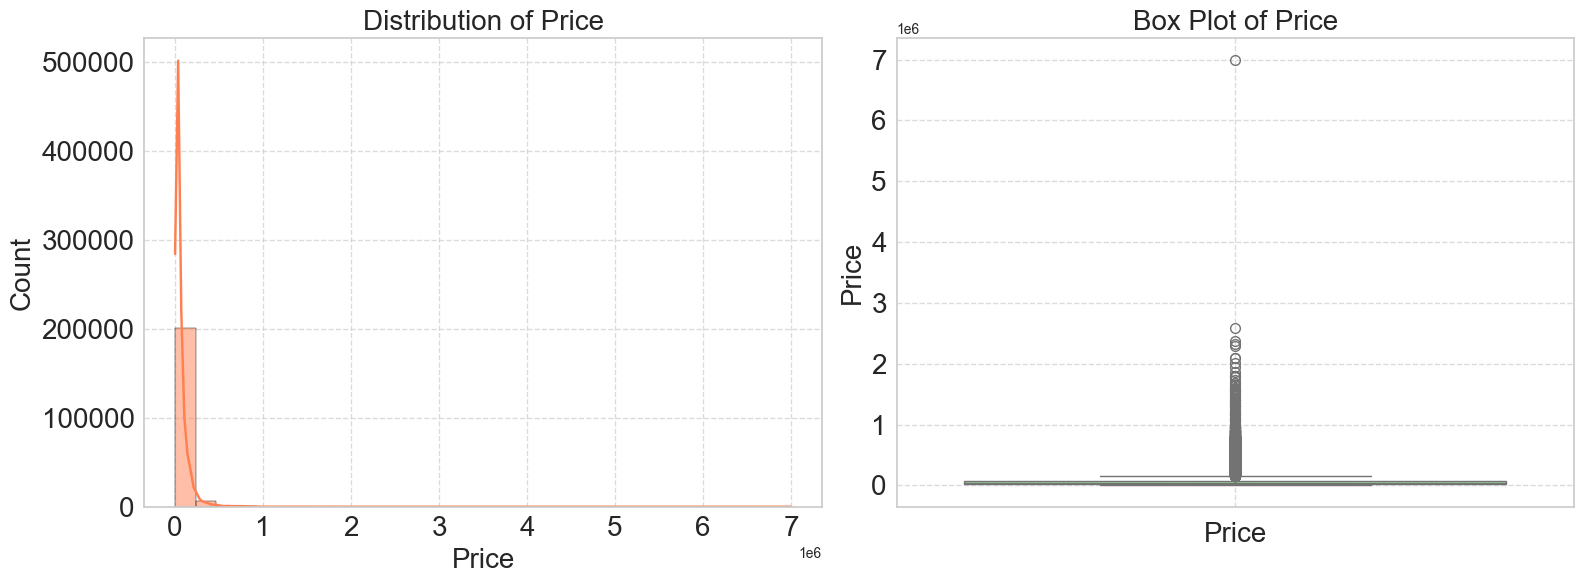

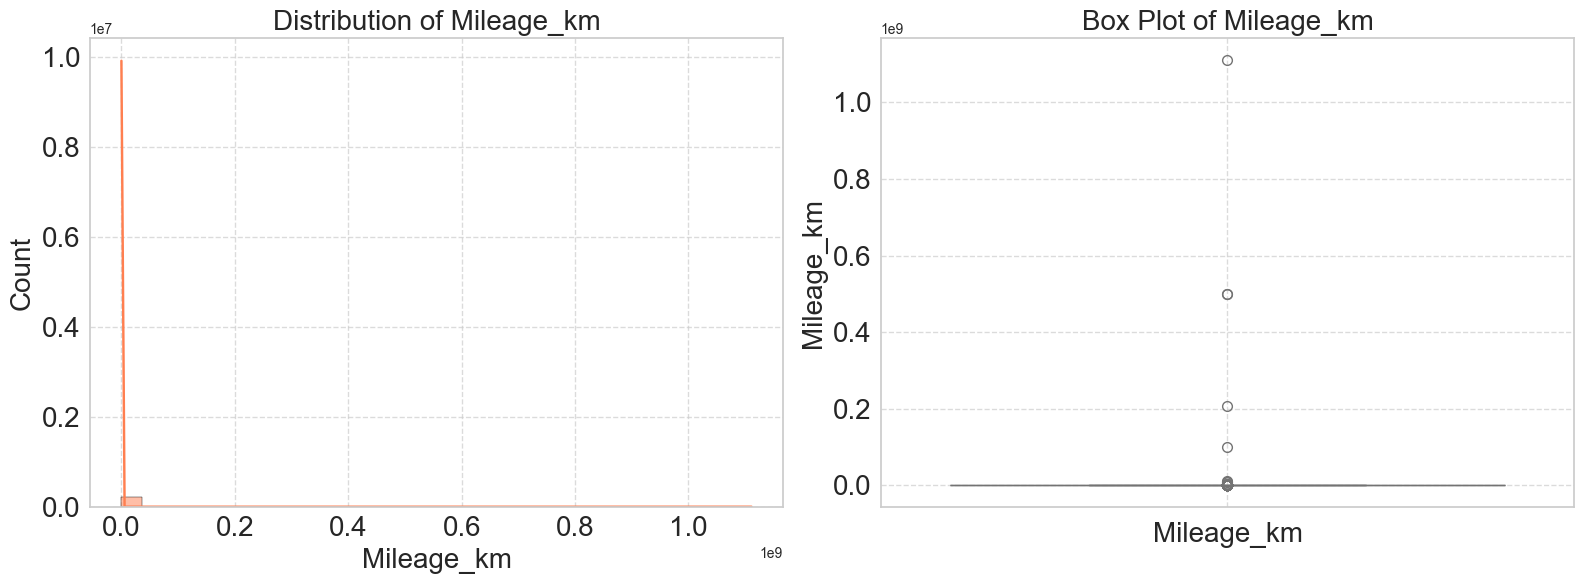

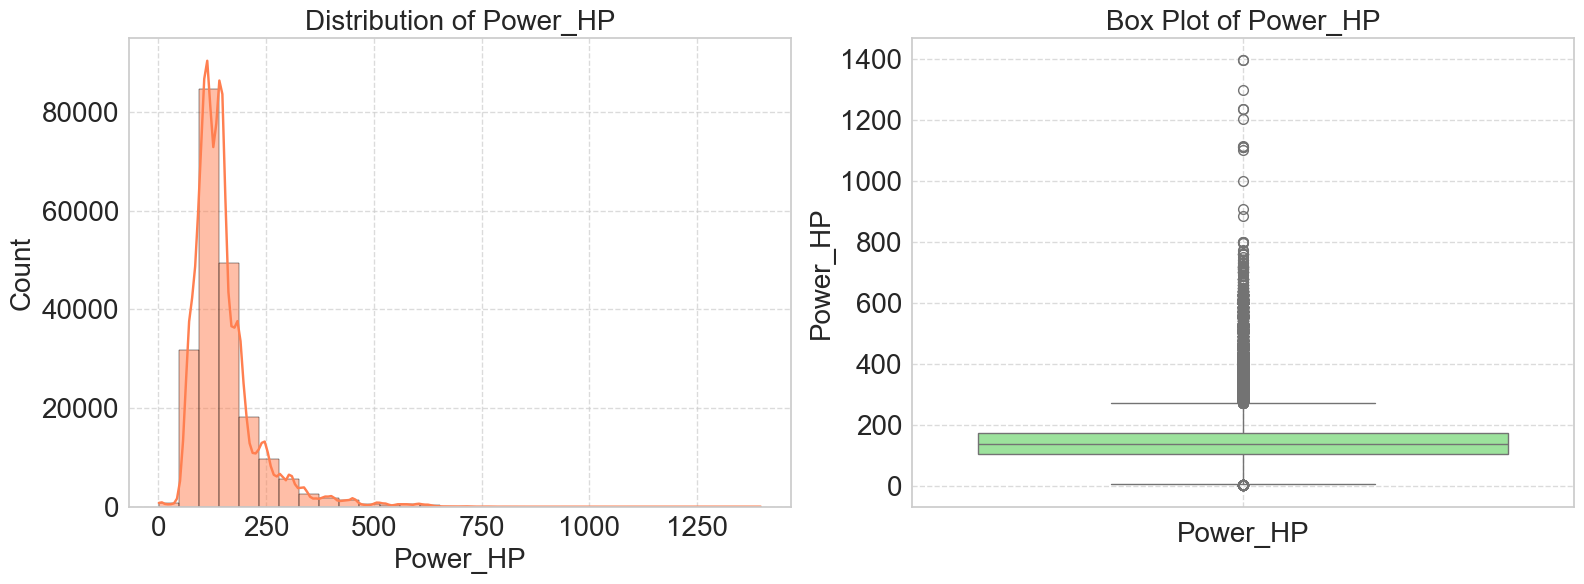

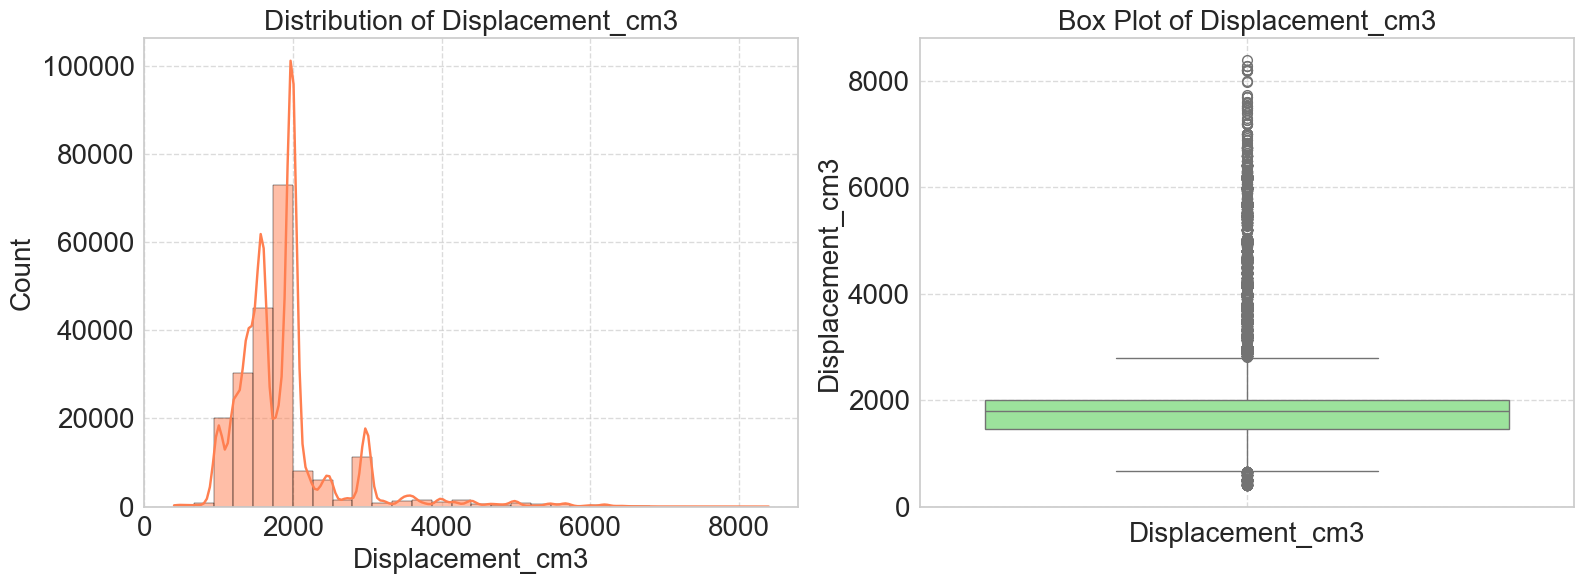

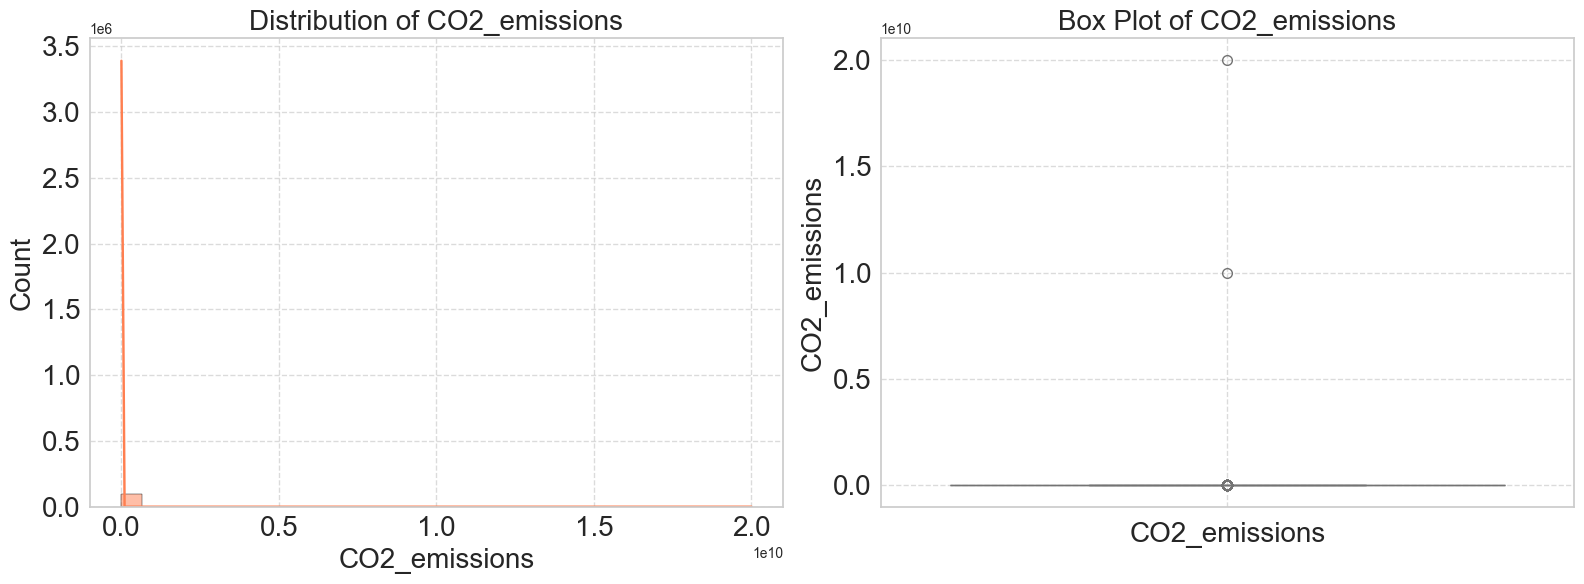

In [181]:

# Create a function to display Distribution and Box Plot of numerical values
def plot_column_analysis(data, columns_list):
    for column in columns_list:
        if column not in data.columns:
            print(f"Column '{column}' is not in the dataset.")
            continue
        
        # Create a figure with 2 subplots (histogram, box plot)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
        
        # Define font properties for x-axis labels
        xlabel_font = {'family': 'serif', 'color': 'darkblue', 'weight': 'bold', 'size': 18}
        
        # 1. Create Histogram on the first axis
        sns.histplot(x=data[column], bins=30, kde=True, ax=axes[0], color="coral")
        axes[0].set_title(f'Distribution of {column}', fontsize=20)
        axes[0].set_xlabel(column, fontsize=20)  # Apply font style to x-axis label
        axes[0].set_ylabel('Count', fontsize=20)
        axes[0].grid(True, linestyle='--', alpha=0.7)
        
        # Increase the font size of the tick labels on both axes
        axes[0].tick_params(axis='both', labelsize=20)  # Increase font size for x and y tick labels
        
        # 2. Create Boxplot on the second axis
        sns.boxplot(y=data[column], ax=axes[1], color="lightgreen")
        axes[1].set_xlabel(column, fontsize=20)  # Apply font style to x-axis label
        axes[1].set_title(f'Box Plot of {column}', fontsize=20)
        axes[1].set_ylabel(column, fontsize=20)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        
        # Increase the font size of the tick labels on both axes
        axes[1].tick_params(axis='both', labelsize=20)  # Increase font size for x and y tick labels
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()


columns_list = ['Price', 'Mileage_km', 'Power_HP', 'Displacement_cm3', 'CO2_emissions']
plot_column_analysis(df_copy, columns_list)


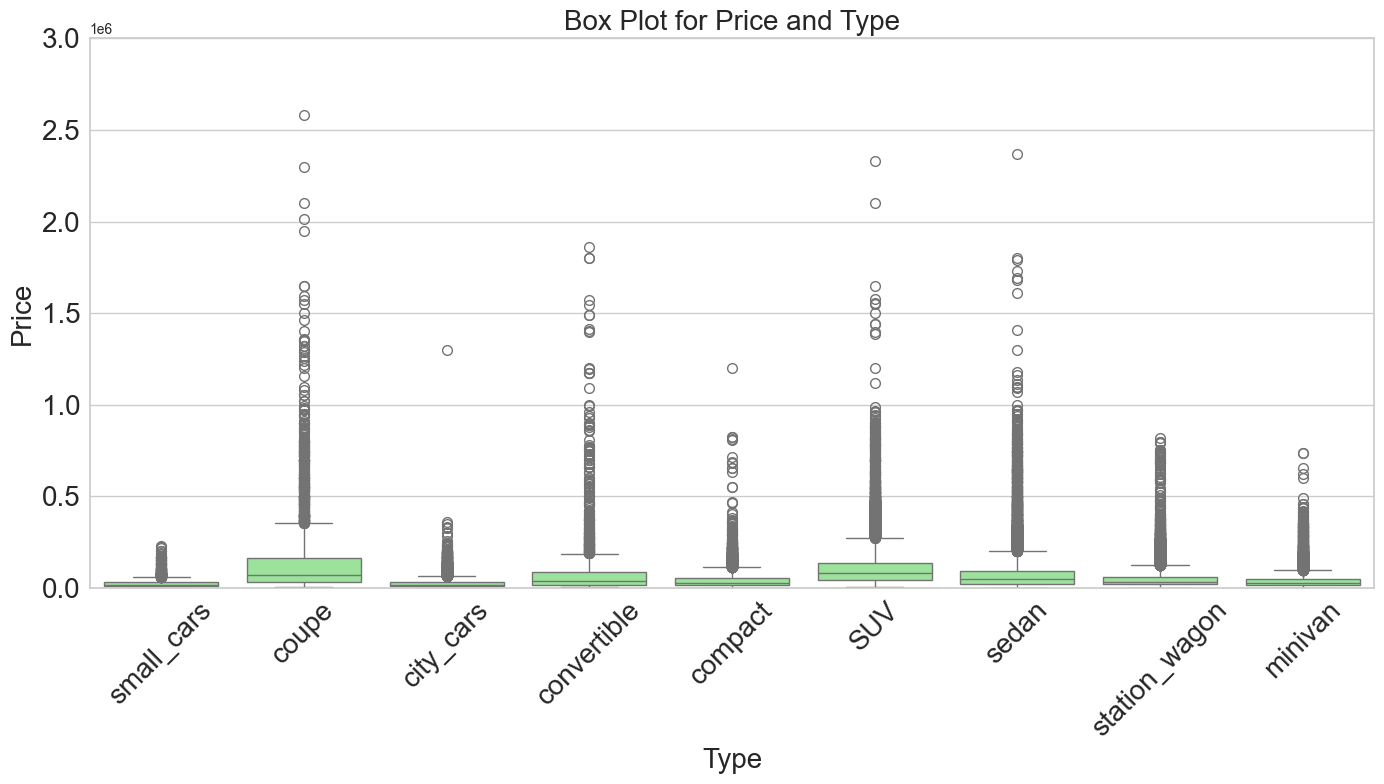

In [182]:
# Adjust the plot with y-axis limit up to 4e6
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_copy, x='Type', y='Price',color="lightgreen")
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,3e6)  # Set y-axis limit to 4,000,000
plt.title("Box Plot for Price and Type", fontsize=20)
plt.xlabel("Type", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
categorical_col = [
 'Condition',
 'Vehicle_brand',
 'Fuel_type',
 'Drive',
 'Transmission',
 'Type'
]

fig , ax = plt.subplots(7,2,figsize =(20,80),dpi=180) 
ax = ax.flatten()  # Flatten the axes array to easily loop over it
for index , col in enumerate(categorical_col):
   

    sns.boxplot(x=df_copy[col] , y=df_copy['Mileage_km'],ax=ax[index])
    ax[index].set_xlabel(col)
    ax[index].set_ylabel('Mileage_km')
    ax[index].tick_params(axis='x', rotation=45, labelsize=10)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()    


Numeric Feature Distribution:
- Price: Outliers present with values up to 1000000 , significantly above the interquartile range.

- Mileage: Some extreme values, including outliers nearing 1 billion kilometers, which is likely an error.

- Doors_number has outliers, with some entries as high as 55.

### 2.2.2 Glance at Object feature

In [106]:
# Create a function to print description of each feature
def freq_table(data,feature):
    
    # Calculate the count of each unique value
    count_feature = data[feature].value_counts()

    # Calculate the percentage of each unique value
    percent_count = round(data[feature].value_counts(normalize =True)*100,2)

    # Combine the counts and percentages into a single DataFrame
    table = pd.concat([count_feature,percent_count],axis=1)
    table.columns = ['Count' , 'Percentage %']
    return table

# Create a function to give us description and frequency table of each variable
objetc_feature = df_copy.select_dtypes(include='O')
# Add frequency table only for object variables
for feature in objetc_feature:
    print(f'Description of {feature}:\n{(df_copy[feature]).describe()}' )
    print(f'Frequency Table\n{freq_table(df_copy,feature)} ')
    print('*'*50)


Description of Condition:
count     208304
unique         2
top         Used
freq      182850
Name: Condition, dtype: object
Frequency Table
            Count  Percentage %
Condition                      
Used       182850         87.78
New         25454         12.22 
**************************************************
Description of Vehicle_brand:
count         208304
unique           108
top       Volkswagen
freq           18455
Name: Vehicle_brand, dtype: object
Frequency Table
               Count  Percentage %
Vehicle_brand                     
Volkswagen     18455          8.86
BMW            16983          8.15
Audi           16730          8.03
Opel           16322          7.84
Ford           16007          7.68
...              ...           ...
FAW                1          0.00
MAN                1          0.00
Talbot             1          0.00
NSU                1          0.00
Vanderhall         1          0.00

[108 rows x 2 columns] 
**********************************

In [107]:
# Checking Missing Values with Counts and Percentages
missing_values = df_copy.isna().sum()
missing_percentages = round((missing_values / df_copy.shape[0]) * 100,2)

# Combine counts and percentages into a DataFrame
missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentages
})

print(missing_info)

                  Missing Count  Missing Percentage
Price                         0                0.00
Condition                     0                0.00
Vehicle_brand                 0                0.00
Production_year               0                0.00
Mileage_km                  983                0.47
Power_HP                    643                0.31
Displacement_cm3           1966                0.94
Fuel_type                     0                0.00
Drive                     15076                7.24
Type                          0                0.00


##### 📊 Missing Values:

- Significant missing data in Vehicle_version, Vehicle_generation, CO2_emissions, First_registration_date , First_owner and Origin_country.

- Columns like Mileage_km, Power_HP, and Displacement_cm3 and Transmission have a smaller percentage of missing values that could be addressed.

### 2.3 Data Preprocessing

1. Handle Missing Values: Fill missing data with appropriate imputation techniques or remove incomplete records if necessary.

2. Remove Duplicates: Ensure data does not have duplicate entries unless they are meaningful.

3. Normalize or Scale Data: Use normalization (min-max scaling) or standardization (z-score) to make data comparable across features.

#### 2.3.1 Handle Missing Values

In [108]:
# Mileage for New vehicles is typically much lower or even one, compared to Used vehicles. Filling missing values globally (using the overall median) might overestimate or underestimate the mileage for certain categories.
# Fill missing values in Mileage_km based on Condition-specific medians

# Calculate medians for Mileage_km grouped by Condition
mileage_medians = df_copy.groupby("Condition")["Mileage_km"].median()

# Fill missing Mileage_km values with the median of their respective Condition group
df_copy["Mileage_km"] = df_copy["Mileage_km"].fillna(
    df_copy["Condition"].map(mileage_medians)
)
# Verify if there are still missing values in Mileage_km
missing_check = df_copy["Mileage_km"].isnull().sum()
print(f"Missing values in Mileage_km after imputation: {missing_check}")


Missing values in Mileage_km after imputation: 0


In [109]:
# List of columns where missing values need to be handled with Median
median_imput_col = ['Power_HP','Displacement_cm3']

# Loop through each column in the list
for col in median_imput_col:
    df_copy[col] = df_copy[col].fillna(df_copy[col].median()) # Fill missing values in the column with the Median


for col in median_imput_col:
    # Count the remaining missing values (if any) in the current column
    missing_check = df_copy[col].isnull().sum()

    # Print the count of missing values after the imputation process
    print(f"Missing values in {col} after imputation: {missing_check}")


Missing values in Power_HP after imputation: 0
Missing values in Displacement_cm3 after imputation: 0


In [110]:
df_copy.head(3)

,Price,Condition,Vehicle_brand,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Type
0,"18,886.42",New,Abarth,2021,1.00,145.00,"1,400.00",Gasoline,Front wheels,small_cars
1,"9,530.85",Used,Abarth,1974,"59,000.00",75.00,"1,100.00",Gasoline,Front wheels,coupe
2,"9,837.59",Used,Abarth,2018,"52,000.00",180.00,"1,368.00",Gasoline,NaN,small_cars


In [8]:
df_copy.to_csv('car_sale_cleaned_dataset.csv', index=False)

#### 2.3.2 Normalize or Scale Data

In [111]:
# Scaling
columns_to_scale = ['Price','Mileage_km','Power_HP','Displacement_cm3']
scaler = StandardScaler()

# Fit and transform the columns to scale
df_copy[columns_to_scale] = scaler.fit_transform(df_copy[columns_to_scale])

### 2.4 Univariate Analysis After Data Preprocessing

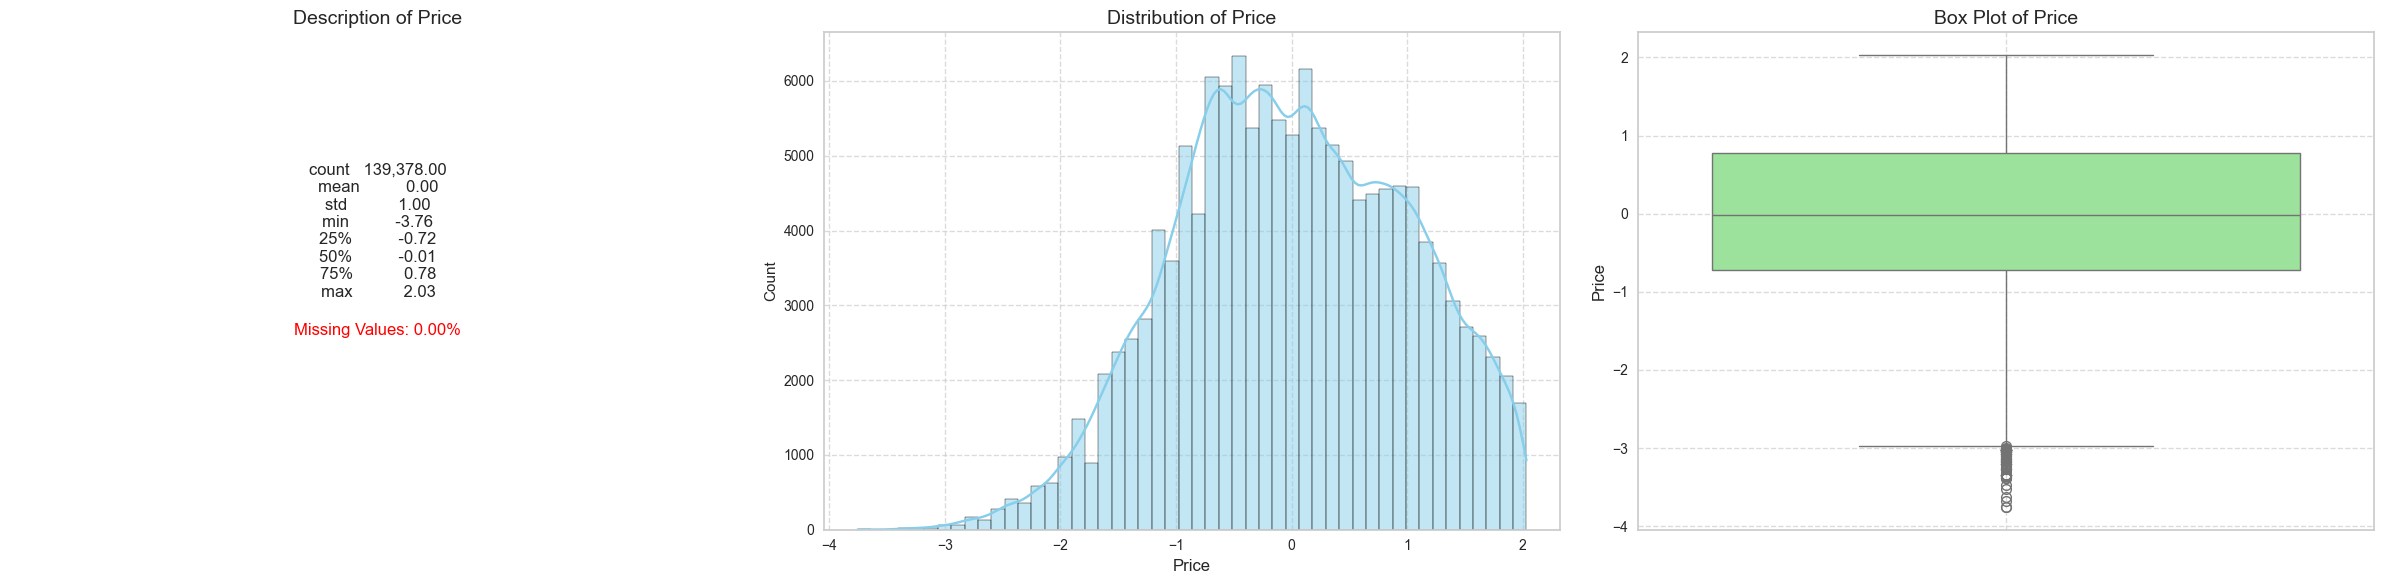

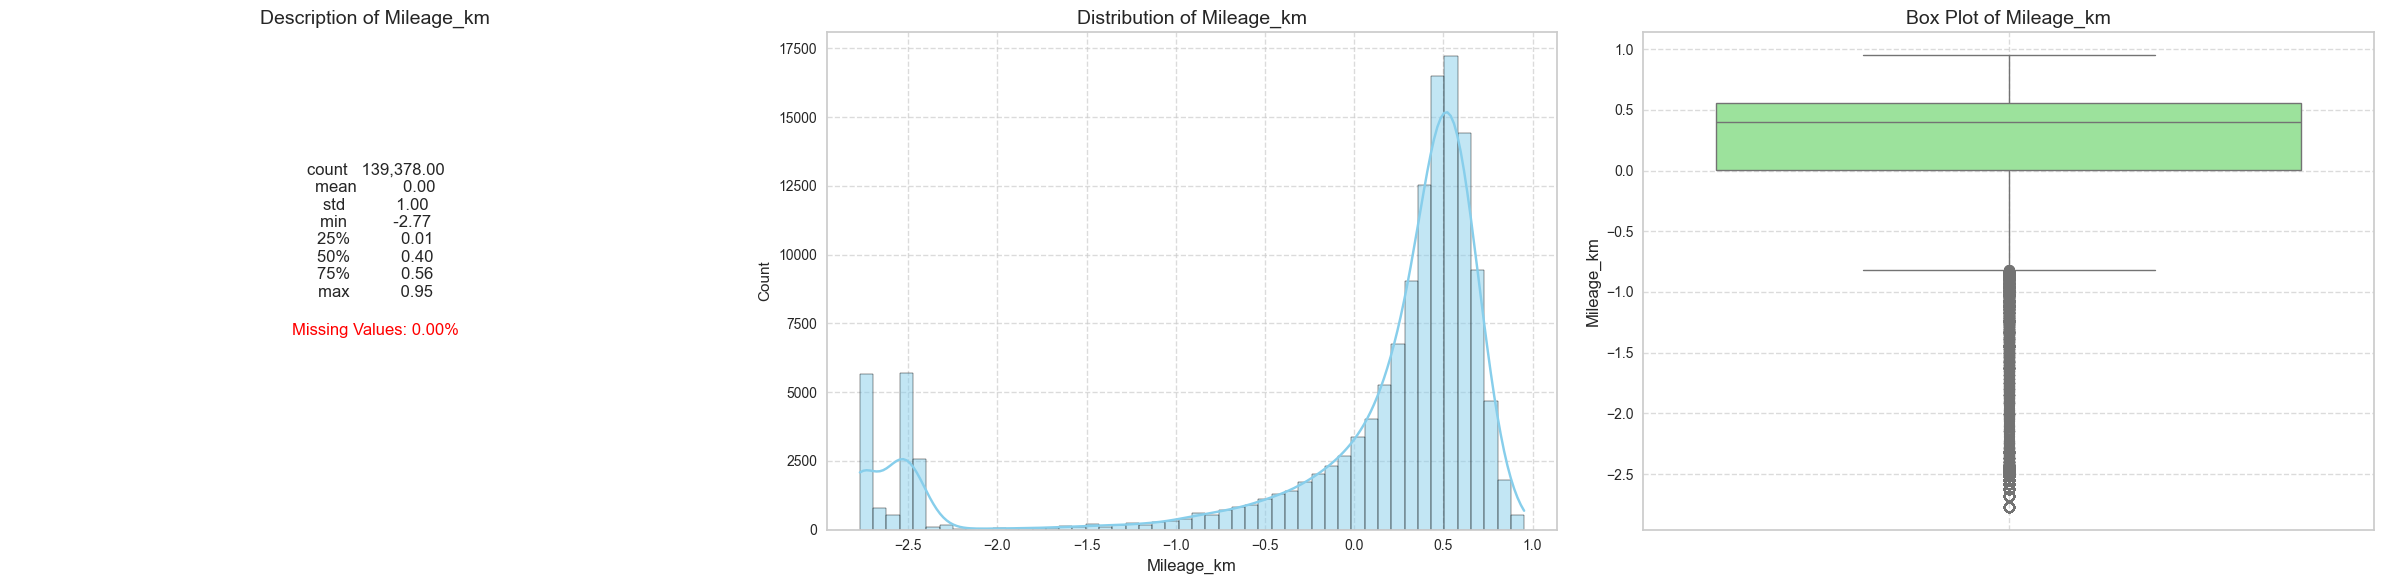

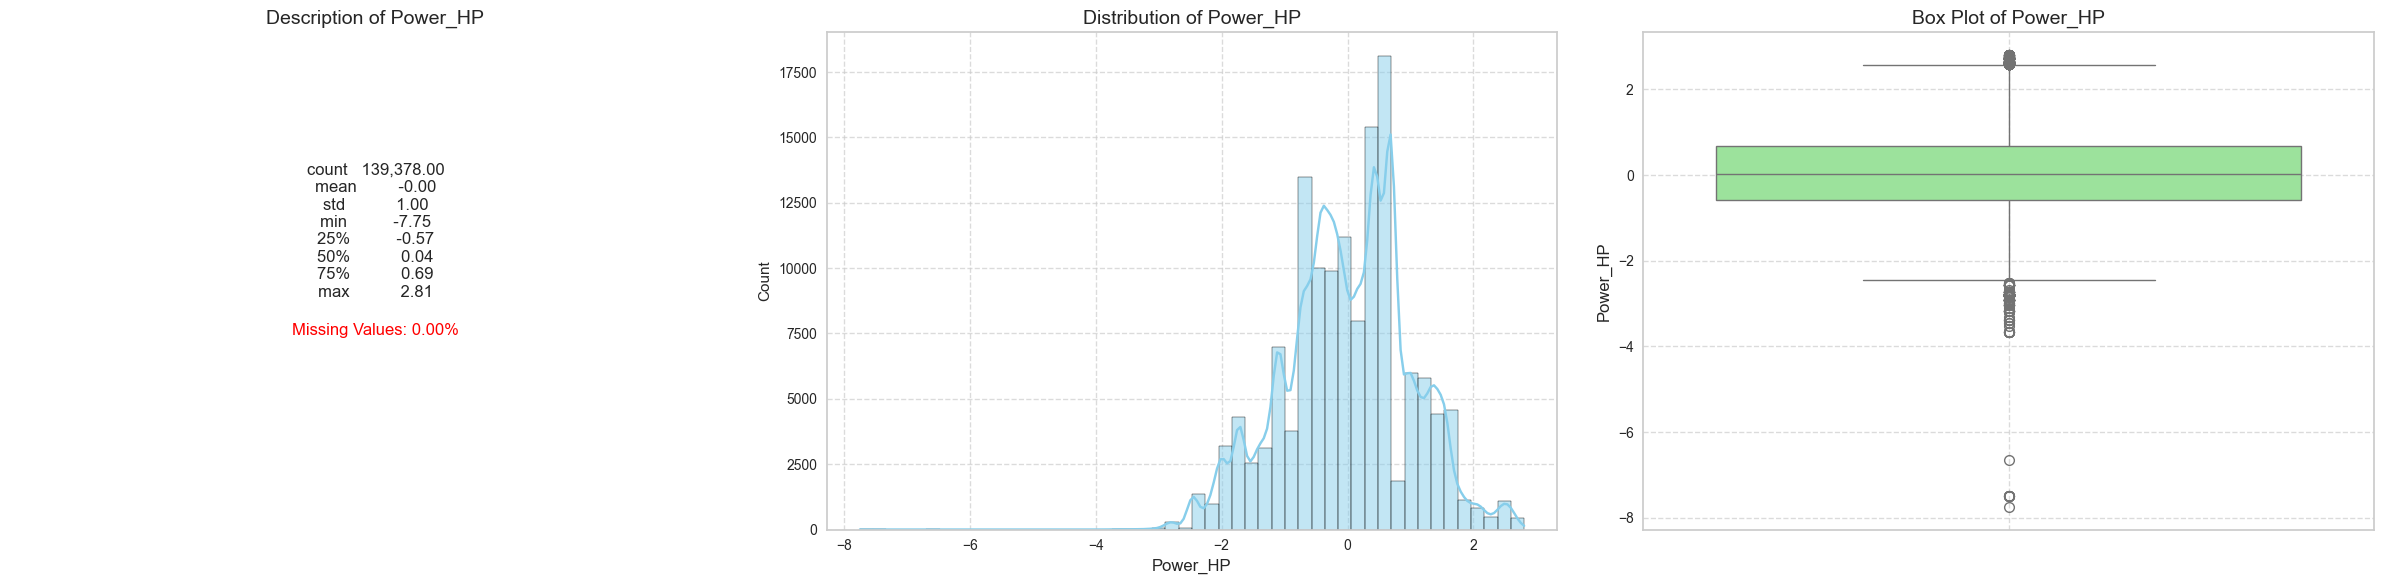

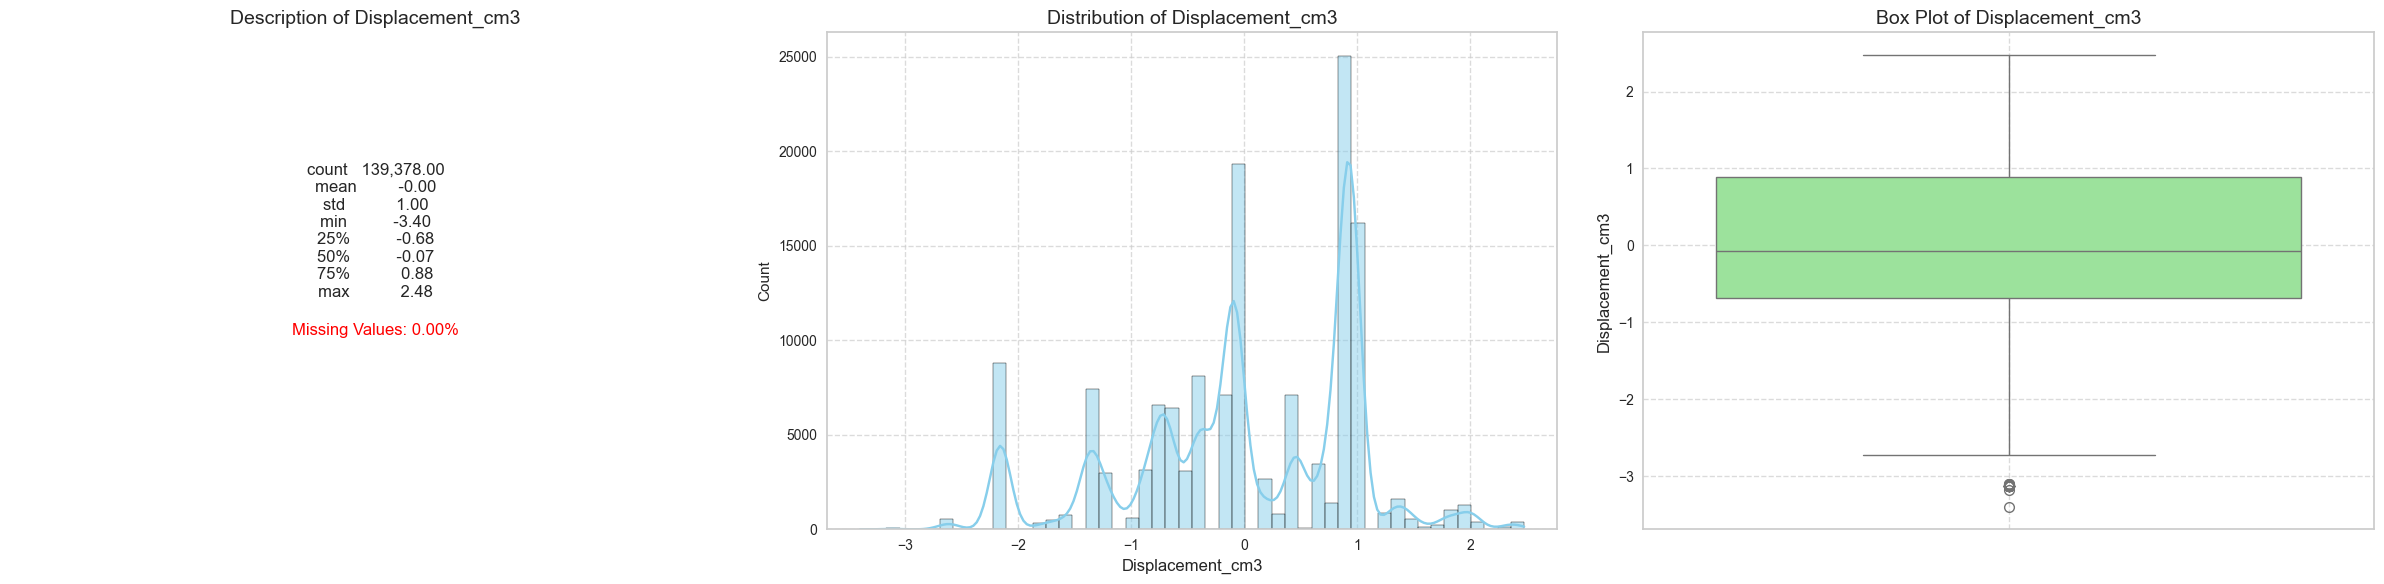

In [19]:
# Create a function to display Distribution and Summary Statistics of numerical value

def plot_column_analysis(data, columns_list):
    for column in columns_list:
        if column not in data.columns:
            print(f"Column '{column}' is not in the dataset.")
            continue
        
        # Calculate missing value percentage
        missing_percentage = data[column].isnull().mean() * 100
        
        # Create a figure with 3 subplots (description, histogram, box plot)
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns
        
        # 1. Show column description and missing values in the first plot
        description = data[column].describe().to_string()
        missing_text = f"Missing Values: {missing_percentage:.2f}%"
        axes[0].text(0.5, 0.6, description, horizontalalignment='center', verticalalignment='center', 
                     fontsize=12, wrap=True)
        axes[0].text(0.5, 0.4, missing_text, horizontalalignment='center', verticalalignment='center', 
                     fontsize=12, color='red')
        axes[0].axis('off')  # Turn off axis for the description text
        axes[0].set_title(f'Description of {column}', fontsize=14)
        
        # 2. Create Histogram on the second axis
        sns.histplot(x=data[column], bins=50, kde=True, ax=axes[1], color="skyblue")
        axes[1].set_title(f'Distribution of {column}', fontsize=14)
        axes[1].set_xlabel(column, fontsize=12)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        
        # 3. Create Boxplot on the third axis
        sns.boxplot(y=data[column], ax=axes[2], color="lightgreen")
        axes[2].set_title(f'Box Plot of {column}', fontsize=14)
        axes[2].set_ylabel(column, fontsize=12)
        axes[2].grid(True, linestyle='--', alpha=0.7)
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()

# Example usage:
columns_list = ['Price', 'Mileage_km', 'Power_HP',
                'Displacement_cm3']
plot_column_analysis(car_sale_cleaned, columns_list)


It seems that transformation did not work well.

In [112]:
# One-hot encoding

def one_hot_encode_with_feature_names(df, one_hot_enc_ft=None):
    if one_hot_enc_ft is None:
        one_hot_enc_ft = ['Condition','Fuel_type', 'Vehicle_brand', 'Type','Drive']
    
    if set(one_hot_enc_ft).issubset(df.columns):
        # Function to perform one-hot encoding
        def one_hot_enc(df, one_hot_enc_ft):
            one_hot_enc = OneHotEncoder(sparse_output=False)  # Ensure the result is a dense array
            one_hot_enc.fit(df[one_hot_enc_ft])
            feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
            encoded_array = one_hot_enc.transform(df[one_hot_enc_ft])
            df_encoded = pd.DataFrame(encoded_array, columns=feat_names_one_hot_enc, index=df.index)
            return df_encoded
        
        # Function to concatenate one-hot encoded features with the rest
        def concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft):
            rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
            df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]], axis=1)
            return df_concat
        
        # Apply the one-hot encoding and concatenate
        one_hot_enc_df = one_hot_enc(df, one_hot_enc_ft)
        full_df_one_hot_enc = concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft)
        return full_df_one_hot_enc
    
    else:
        print("One or more specified features are not in the dataframe")
        return df
encoded_data = one_hot_encode_with_feature_names(df_copy)



In [113]:
car_sale_cleaned_data = pd.read_csv('car_sale_cleaned_dataset.csv')

Implement Isolation Forest for global anomaly detection.


In [114]:
from sklearn.ensemble import IsolationForest

# Selecting relevant features for anomaly detection
features = encoded_data.select_dtypes(exclude='O').columns
X = encoded_data[features]

# Applying Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
encoded_data['Anomaly'] = iso_forest.fit_predict(X)
car_sale_cleaned_data['Anomaly'] = iso_forest.fit_predict(X)

# Counting anomalies
anomaly_counts = encoded_data['Anomaly'].value_counts()

# Display anomalies and their count
anomalies = encoded_data[encoded_data['Anomaly'] == -1]
anomaly_counts


Anomaly
 1    206221
-1      2083
Name: count, dtype: int64

In [115]:
anomalies_copy = car_sale_cleaned_data[car_sale_cleaned_data['Anomaly'] == -1]

In [14]:
# Define ranges for eps and min_samples
eps_values = np.arange(0.2, 0.6, 0.1)  # Range for eps (neighborhood radius)
min_samples_values = range(5, 20, 5)  # Range for min_samples (minimum points per cluster)

sil_scores = []  # To store Silhouette Scores
params = []      # To store (eps, min_samples) combinations

# Loop through eps and min_samples combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(anomalies)

        # Exclude noise points (labeled as -1) and calculate Silhouette Score
        if len(set(labels)) > 1 and np.sum(labels != -1) > 1:
            filtered_data = anomalies[labels != -1]
            filtered_labels = labels[labels != -1]
            score = silhouette_score(filtered_data, filtered_labels)
            sil_scores.append(score)
            params.append((eps, min_samples))
        else:
            sil_scores.append(-1)  # Assign invalid score for bad clustering
            params.append((eps, min_samples))

# Display the best parameter combination
best_idx = np.argmax(sil_scores)
print(f"Best Silhouette Score: {sil_scores[best_idx]:.3f}")
print(f"Best Parameters: eps={params[best_idx][0]}, min_samples={params[best_idx][1]}")


Best Silhouette Score: 0.949
Best Parameters: eps=0.2, min_samples=15


In [15]:

# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=15)
anomalies['DBSCAN_Label'] = dbscan.fit_predict(anomalies)
anomalies_copy['DBSCAN_Label']= dbscan.fit_predict(anomalies)
# Analyze clusters and anomalies
cluster_counts = anomalies['DBSCAN_Label'].value_counts()
cluster_counts


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_35565/1181825712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['DBSCAN_Label'] = dbscan.fit_predict(anomalies)
/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_35565/1181825712.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_copy['DBSCAN_Label']= dbscan.fit_predict(anomalies)


DBSCAN_Label
-1    1961
 3      32
 0      28
 4      24
 1      23
 2      16
Name: count, dtype: int64

In [21]:
dbscan_anomalies = anomalies_copy[anomalies_copy['DBSCAN_Label'] == -1]
dbscan_anomalies.shape

(1961, 12)

In [ ]:
dbscan_anomalies.describe()


,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Anomaly,DBSCAN_Label
count,"1,961.00","1,961.00","1,961.00","1,961.00","1,961.00","1,961.00","1,961.00"
mean,"101,647.41","2,018.46","12,116.60",401.85,"3,364.78",-1.00,-1.00
std,"71,774.80",8.83,"45,706.26",174.06,"1,480.88",0.00,0.00
min,"1,205.05","1,922.00",1.00,1.00,479.00,-1.00,-1.00
25%,"53,110.06","2,020.00",5.00,263.00,"1,969.00",-1.00,-1.00
50%,"92,004.91","2,021.00",6.00,405.00,"2,998.00",-1.00,-1.00
75%,"139,303.78","2,021.00",499.00,557.00,"4,395.00",-1.00,-1.00
max,"1,464,807.00","2,021.00","590,000.00","1,398.00","8,400.00",-1.00,-1.00


In [42]:
dbscan_anomalies['Condition'].value_counts(normalize=True)*100

Condition
New    79.45
Used   20.55
Name: proportion, dtype: float64

In [40]:
dbscan_anomalies[dbscan_anomalies['Condition']=='New'].describe()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Anomaly,DBSCAN_Label
count,"1,558.00","1,558.00","1,558.00","1,558.00","1,558.00","1,558.00","1,558.00"
mean,"100,990.10","2,020.58",285.59,378.67,"2,981.94",-1.00,-1.00
std,"69,937.27",0.59,"1,187.14",169.48,"1,273.22",0.00,0.00
min,"4,360.09","2,018.00",1.00,4.00,479.00,-1.00,-1.00
25%,"54,758.57","2,020.00",1.00,225.00,"1,798.00",-1.00,-1.00
50%,"90,280.15","2,021.00",5.00,381.00,"2,925.00",-1.00,-1.00
75%,"136,028.07","2,021.00",10.00,525.00,"3,996.00",-1.00,-1.00
max,"1,464,807.00","2,021.00","13,790.00","1,398.00","6,749.00",-1.00,-1.00


In [70]:
q = dbscan_anomalies[dbscan_anomalies['Condition']=='New']
q['Drive'].value_counts(normalize=True)*100
q['Type'].value_counts(normalize=True)*100
#q[q['Drive']== '4x4 (attached automatically)']['Type'].value_counts(normalize=True)*100
q['Drive'].value_counts(normalize=True)*100
q['Fuel_type'].value_counts(normalize=True)*100


Fuel_type
Gasoline         42.62
Hybrid           26.96
Electric         22.08
Diesel            7.64
Gasoline + LPG    0.71
Name: proportion, dtype: float64

In [78]:
q[q['Type']=='convertible'].describe()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Anomaly,DBSCAN_Label
count,22.00,22.00,22.00,22.00,22.00,22.00,22.00
mean,"150,637.71","2,020.27",8.95,516.59,"4,505.18",-1.00,-1.00
std,"102,013.52",0.70,5.79,88.08,579.13,0.00,0.00
min,"56,900.27","2,019.00",1.00,400.00,"2,981.00",-1.00,-1.00
25%,"60,473.79","2,020.00",4.25,450.00,"3,990.50",-1.00,-1.00
50%,"126,409.74","2,020.00",10.00,455.00,"4,673.00",-1.00,-1.00
75%,"190,932.23","2,021.00",10.00,600.00,"4,951.00",-1.00,-1.00
max,"408,008.02","2,021.00",20.00,720.00,"5,204.00",-1.00,-1.00


In [72]:
# Group and count
result = q.groupby(['Type', 'Vehicle_brand']).size()

# Calculate percentages
percentages = (result / result.sum()) * 100

# Combine counts and percentages into a DataFrame for better visualization
sorted_result = result.sort_values(ascending=False).reset_index(name='Count')
sorted_result['Percentage'] = (sorted_result['Count'] / sorted_result['Count'].sum()) * 100

print(sorted_result)


            Type  Vehicle_brand  Count  Percentage
0          sedan            BMW    176       11.30
1            SUV            BMW    106        6.80
2            SUV           Audi     95        6.10
3            SUV  Mercedes-Benz     89        5.71
4          sedan  Mercedes-Benz     73        4.69
..           ...            ...    ...         ...
110  convertible         Jaguar      1        0.06
111        sedan    Rolls-Royce      1        0.06
112  convertible           Audi      1        0.06
113        coupe          Lexus      1        0.06
114      minivan        Peugeot      1        0.06

[115 rows x 4 columns]


In [73]:
q = dbscan_anomalies[dbscan_anomalies['Condition']=='New']
q['Vehicle_brand'].value_counts(normalize=True)*100
result = q.groupby(['Vehicle_brand', 'Type']).size()  # Group and count
sorted_result = result.sort_values(ascending=False)   # Sort by count in descending order
print(sorted_result)


Vehicle_brand  Type      
BMW            sedan         176
               SUV           106
Audi           SUV            95
Mercedes-Benz  SUV            89
               sedan          73
                            ... 
Dodge          compact         1
Dacia          small_cars      1
Smart          compact         1
Dacia          city_cars       1
Škoda          small_cars      1
Length: 115, dtype: int64


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_35565/3484942605.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


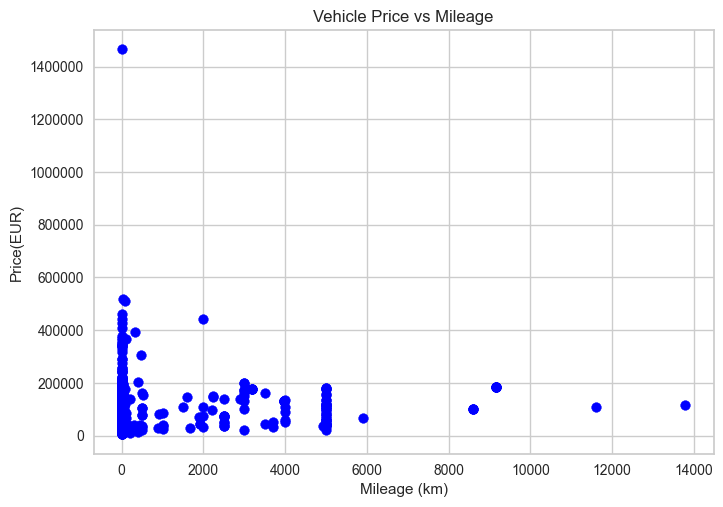

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

q = dbscan_anomalies[dbscan_anomalies['Condition']=='New']

plt.scatter(q['Mileage_km'], 
            q['Price'], 
            color='blue')
plt.xlabel('Mileage (km)')
plt.ylabel('Price(EUR)')
plt.title('Vehicle Price vs Mileage')
plt.legend()

# Disable scientific notation
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')  # Ensures plain formatting

plt.show()
